In [44]:
"""
This Jupyter notebook has been used to:
1.) Extract ingredient lists and ingredient amounts out of curated german recipe data
2.) The recipe amounts have been converted between different units to [g] per ingredient item
3.) The ingredients were matched to their corresponding food items of the CO2 equivalent lookup table
4.) The CO2 equivalents per recipe has been calculated
5.) The recipes have been ranked according to the cummulated CO2 equivalents
6.) 5 different consumer types with decreasing sensitivity to CO2 equivalents of food have been simulated in random walk
experiments to idenfy the influence of diets on the yearly CO2 per person/per year
7.) The CO2 ranked recipes can be used by the FoodAbdruck API to recommend meals based on the shopping list and based 
on the most carbon poor combinations of ingredients.
"""

In [ ]:
#Data Source of the recipes + copy right -> http://kochbuch.unix-ag.uni-kl.de/

In [524]:
import json
import pandas as pd
import re
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from copy import deepcopy
from nltk.stem import SnowballStemmer
from nltk.stem.cistem import Cistem
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union
from random import randrange
tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer('german')

In [ ]:
__author__: 'Christoph Hiemenz'
__version__: 0.01
__status__: 'exploration'
__contact__: 'christoph.hiemenz@web.de'

In [179]:
#fileHandler = open ("C:/Users/christoph.hiemenz/Desktop/kochbuch_unix_ag_uni_kl_de.txt", "r") 
# In order to get a manually curated 
"""
In order to get a representitive list of recipes without the need to pay for the expensive
REST API service keys for the vast majority of recipe online service providers, 
a txt file was manually curated from an online recipe database --> source:
"Die Rezeptesammlung der Unix-AG, kochbuch@unix-ag.uni-kl.de"
"""
#Load the txt file including the recipe data
fileHandler = open ("C:/Users/christoph.hiemenz/Desktop/kochbuch_unix_ag_uni_kl_de_LONG.txt", "r") 
listOfLines = fileHandler.readlines()
# Close file 
fileHandler.close()

In [525]:
def extract_ingredients(cookbook_entry: str)-> List[str]:
    """
    This method is used to get the ingredients from the txt line entries based on regex tokenization 
    :param cookbook_entry: input string which contains concatenated cookbook ingredient entries
    :return: return tokenizet + only non numeric tokens
    """
    try:
        return [j for j in tokenizer.tokenize(cookbook_entry) if len(j)>2 and j.isalpha()]
    except:
        return cookbook_entry

In [183]:
def return_number_unit_item(input_entry: List[str])-> Tuple:
    """
    This function returns the name of a recipe list item in addition to a unit (if present) and an amount
    :param input_entry: List of strings which contain concatenated information about the item amount id and unit
    :return: For each individual recipe list ingredient an amount, unit and name of the item is returned
    """    
    if len(input_entry)>2:
        if len(input_entry[1])<=2:
            return (return_decimal_number(input_entry[0]), return_unit_conversion(input_entry[1]), input_entry[-1])
        else:
            return (return_decimal_number(input_entry[0]), input_entry[-1])
    else:
        return (return_decimal_number(input_entry[0]), input_entry[-1])

In [184]:
def extract_ingredients_and_numbers(cookbook_entry: str)-> List[Tuple]:
    """
    This fuction returns a list of Tuples which contain pairs of ingredient names and the ingredient amounts for a 
    single recipe entry
    :param cookbook_entry: This function accepts a cookbook entry containing comma separated information about the 
    individual parameters
    :return: List of tuples with information about the ingredient names and amounts    
    """
    pattern1 = r"\d+.*"
    span = [re.search(pattern1, i) for i in cookbook_entry.split(',') if re.search(pattern1, i)]    
    get_individual_items = [i[re.search(pattern1, i).span()[0]:re.search(pattern1, i).span()[1]] for i in cookbook_entry.split(',') if re.search(pattern1, i)]
    get_key_val_pairs = [return_number_unit_item(word_tokenize(j)) for j in get_individual_items]
    return get_key_val_pairs    

In [185]:
def return_decimal_number(input_entry: str)-> float:
    """
    This function cleans up the ingredient amount specifications e.g. 1/4 has to be converted to a python float
    being 0.25 also the german , has to be replaced by .
    :param input_entry: The function accepts a string including the definition of an recipe ingredient amount in wrong 
    format and of wrong data type
    :return: The function returns the amount of a recipe ingredient as a floating point number    
    """
    if len(input_entry.split('/'))>1:
        return float(str(input_entry.split('/')[0]))/float(str(input_entry.split('/')[1]))
    else:
        input_entry = input_entry.replace(',','.')        
        try:
            return float(input_entry)
        except:
            return None

In [186]:
def return_unit_conversion(input_entry):
    """
    This function accepts a amount unit type specification and returns a conversion factor to [g]
    e.g. 1 kg of tomatoes is converted to 1000 g (multiplication factor 1000)
    :param input_entry: The function accepts a string as an input 
    :return: this method returns a conversion factor if the string matches the predefined conversion lookup keys if there is
    no matching conversion factor the amount is not converted (conversion factor 1)
    """
    if input_entry in unit_lookup.keys():
        return unit_lookup[input_entry]
    else:
        return 1

In [ ]:
def get_number(input_weight: str) -> str:
    """
    This function gets a string containing the weight values and extracts the actual number value as a substring
    :param input_weight: input string which contains a number value to be extracted as a substring
    :return: substring which just consists of numeric values"
    """
    if re.search('\d+',input_weight):
        return input_weight[re.search('\d*',input_weight).span()[0]:re.search('\d*',input_weight).span()[1]]
    else:
        return -100

In [ ]:
def get_food_item(input_item: str) -> str:
    """
    This function extracts an actual food item e.g. Butter, Tomato from the messy input string ingredient list entry
    :param input_item: input string which contains the name of a food recipe ingredient entry
    :return: return recipe ingredient item name if no item can be found, "NO_ITEM" is returned
    """
    if re.search('\w+',input_item):
        return input_item[re.search('\w+',input_item).span()[0]:re.search('\w+',input_item).span()[1]]
    else:
        return 'NO_ITEM'    

In [ ]:
def perfect_match_or_substring_match(item_gramm_tuple: Tuple)-> Tuple:
    """
    This function assesses whether the recipe item is either a perfect match of a CO2 food product lookup dictionary
    if it is a match (perfect or substring match) the co2 value in [kg] per 100 g of the food product is returned
    :param item_gramm_tuple: Input tuple containing an ingredient name of a recipe list in addition to the amount 
    of the recipe item
    :return: tuple with the recipe ingredient name, its amount, the matched product name,
    the matched product co2 equivalents
    """
    get_match = []
    if item_gramm_tuple[0] in product_co2_dict.keys():
        get_match = (item_gramm_tuple[0], item_gramm_tuple[1], item_gramm_tuple[0], product_co2_dict[item_gramm_tuple[0]])
    else:
        get_match = []
        for prod, co2g in product_co2_dict.items():
            if re.search(item_gramm_tuple[0], prod):
                get_match = (item_gramm_tuple[0], item_gramm_tuple[1], prod, co2g)
    if get_match:
        return get_match
    else:
        return []   

In [ ]:
def compute_co2_per_recipe(input_dict: Dict) -> List[Tuple]:
    """
    This function accepts the amounts of items converted into gramm including the respective ingredient names
    and returns the names in addition to the amounts in grams
    :param compute_co2_per_recipe: Dictionary containing all information about a single recipe title -> 
    :return: List of Tuples with item names and the ingredient amounts in gramm    
    """
    return [(i[0],i[1]) for i in input_dict['items_in_gramm']]

In [189]:
unit_lookup = {'tb':15,'ts':4,'ml':100,'l':1000,'g':1,'kg':1000,'mg':0.001, 'dl':100,'cup':225, 'Tasse':225, 'EL':15, 'sn':1, 'cn':1}

In [190]:
ctr_remeber_ingredients = 1000000000000
remeber_recipe_text = 100000000000000  
list_of_recipes = []
recipe_data = {}
title = False
ctr=-1
for j in listOfLines:    
    ctr+=1
    if re.search('TTTTT',j): 
        recipe_data = {}
        recipe_data['title'] = listOfLines[ctr+1][:-1]        
        ingredient_string = '' 
        ingredient_string_comma = ''
        ctr_remeber_ingredients = 1000000000000             
    if re.search('ZZZZZ:',j):
        ctr_remeber_ingredients = ctr            
    if ctr >= ctr_remeber_ingredients + 1 and not re.search('RRRRR', j):
        ingredient_string = ingredient_string + ' ' + j[:-1]    
        ingredient_string_comma = ingredient_string_comma + ',' + j[:-1]
    if re.search('RRRRR', j):
        recipe_string= ''
        recipe_data['ingredients'] = extract_ingredients(ingredient_string)  
        recipe_data['ingredients_and_numbers'] = extract_ingredients_and_numbers(ingredient_string_comma)
        remeber_recipe_text = ctr   
    if ctr >= remeber_recipe_text + 1:        
        recipe_string = recipe_string + ' ' + j[:-1]  
         
    if ctr>0 and re.search('TTTTT',j):        
        recipe_data['recipe_text'] = recipe_string
        list_of_recipes.append(recipe_data)  
        recipe_string = ''
        remeber_recipe_text = 100000000000000   

In [193]:
fileHandlerLookup = open ("C:/Users/christoph.hiemenz/Desktop/191026_hashtable_food_items.txt", "r",encoding='utf-8') 
# Get list of all lines in file
listOfLinesLookup = fileHandlerLookup.readlines()
# Close file 
fileHandlerLookup.close()

In [196]:
sign = 1
item_weight_lookup = {}

for j in range(len(listOfLinesLookup)):
    sign*=-1
    if sign <1:
        tmp_item = get_food_item(listOfLinesLookup[j][:-1])
    else:
        tmp_value = float(get_number(listOfLinesLookup[j]))
        item_weight_lookup[tmp_item] = tmp_value      

In [199]:
output_json = []
for rezept in list_of_recipes:
    tmp_rezept = deepcopy(rezept)  
    ingredients_conv = [return_item_and_weight_gramm(i) for i in rezept['ingredients_and_numbers'] if return_item_and_weight_gramm(i)]
    tmp_rezept['items_in_gramm'] = ingredients_conv
    output_json.append(tmp_rezept)

In [200]:
#get_weight_item_conv = [[return_item_and_weight_gramm(i['ingredients_and_numbers']) for i in j] for j in list_of_recipes]

In [201]:
output_json

[{'title': 'Aal in Dillsosse',
  'recipe_text': '   Aal ausnehmen. Nicht haeuten. Waschen. Innen leicht salzen. Am Kopf und   Schwanz zusammenbinden. Mit heissem Essig ueberbruehen. Dadurch wird der   Fisch blau. Wasser erhitzen. Die Zutaten fuer den Sud darin aufkochen.   Aal reinlegen. 20 bis 30 Minuten darin ziehen, nicht kochen lassen,   damit der Fisch nicht zerfaellt.     In der Zwischenzeit die Sauce Hollandaise zubereiten. Dazu Eigelb mit   Wein im Wasserbad schaumig schlagen. Die geschmolzene, lauwarme,   abgeschoepfte Butter essloeffelweise unterziehen. Mit Worcestersosse,   Zitronensaft, Salz und Pfeffer abschmecken.     Aal aus dem Sud nehmen. Im ganzen auf einer Platte anrichten. Mit   halben Zitronenscheiben und Dillstraeusschen garnieren. 1 Zitrone   halbieren, aushoehlen. Haelften mit Sauce Hollandaise fuellen, mit   Kapern und gehackter Petersilie garnieren. Oder die Sosse in ein   Schaelchen fuellen. In die Aalmitte stellen. TTTTT:',
  'ingredients': ['Aal',
   'Zwieb

In [202]:
with open("C:/Users/christoph.hiemenz/Desktop/191026_cleaned_kochbuch.json","w",encoding="utf-8") as write_cleaned_recipe:
    json.dump(output_json, write_cleaned_recipe, ensure_ascii=False)

In [203]:
with open("C:/Users/christoph.hiemenz/Desktop/191026_cleaned_kochbuch.json","r",encoding="utf-8") as in_f:
    kochbuch_in = json.load(in_f)

In [205]:
kochbuch_sentences = [[j[:-1].strip() for j in sent_tokenize(i['recipe_text'])] for i in kochbuch_in]

In [ ]:
"""
Get word tokenized sentences per recipe as a corpus to train a FastText Model which enables the clustering 
of recipes based on the sentence word embedding similarities.
The individual recipies can be clustered by hierarchical clustering, k-means clustering, SOM, DBSCAN...
The idea is that the recipes can be clustered based on the aggregated sentence vectors in addition to the
continuous Bag of Words encoded ingredient vectors
A choice between similar recipes (clustered recipes) should be done based on the ranking of CO2 equivalent scores within 
recipe clusters
"""
recipe_corpus = []
for document in kochbuch_sentences:
    for sentence in document:
        recipe_corpus.append(word_tokenize(sentence))   

In [248]:
gramm_2_co2_df = pd.read_csv("C:/Users/christoph.hiemenz/Desktop/191027_co2_per_products.csv", sep=",",)

In [249]:
gramm_2_co2_df

,Produkt,Oberkategorie,co2kgper_g,portion_g,packung_g,none
0,Butter,Fette/Öle,0.92,10.0,250.0,NaN
1,Butter und Margarine z.B Rama mit Butter,Fette/Öle,0.34,10.0,250.0,NaN
2,Halbfettmargarine,Fette/Öle,0.11,10.0,250.0,NaN
3,Olivenöl,Fette/Öle,0.31,10.0,750.0,NaN
4,Palmfett zum Braten,Fette/Öle,0.14,10.0,250.0,NaN
5,Pflanzencreme,Fette/Öle,0.02,10.0,250.0,NaN
6,Rapsöl,Fette/Öle,0.27,10.0,750.0,NaN
7,Sonnenblumenöl,Fette/Öle,0.22,10.0,750.0,NaN
8,Veganes Streichfett,Fette/Öle,0.17,10.0,250.0,NaN
9,Sesamöl,Fette/Öle,0.38,10.0,250.0,NaN


In [260]:
product_co2_dict = {}
for prod, g2c in zip(list(gramm_2_co2_df.Produkt),list(gramm_2_co2_df.co2kgper_g)):
    product_co2_dict[prod]=g2c

In [344]:
recipe_list_co2_equivalents = []
for entry in kochbuch_in:
    tmp_entry = deepcopy(entry)
    if tmp_entry['items_in_gramm']:
        if (np.sum([')'==i[0] for i in tmp_entry['items_in_gramm']])==0):        
            transformed_list = [perfect_match_or_substring_match(i) for i in tmp_entry['items_in_gramm']]
            item_with_estimated_c02 = [(i[2],(i[1]/100)*i[3]) for i in transformed_list if len(i)>0]
            aggregated_score = [h[1] for h in item_with_estimated_c02]
            if aggregated_score:
                tmp_entry['overall_co2']=np.sum(aggregated_score)            
            tmp_entry['co2_equivalents'] = item_with_estimated_c02
            recipe_list_co2_equivalents.append(tmp_entry)               

In [383]:
filtered_recipes = [h for h in recipe_list_co2_equivalents if 'overall_co2' in h.keys()]
len(filtered_recipes)

150

In [385]:
result_df = pd.DataFrame(filtered_recipes)

In [387]:
result_df = result_df.sort_values('overall_co2')
get_first = result_df.iloc[1:20,:]

In [485]:
#Here the least carbon intensive meals are represented
get_first

,co2_equivalents,ingredients,ingredients_and_numbers,items_in_gramm,overall_co2,recipe_text,title
11,"[(Salz, 0.0003)]","[Knoblauchzehen, Eigelb, Prise, Salz, Olivenoe...","[[8.0, Knoblauchzehen], [2.0, Eigelb], [1.0, S...","[[Eigelb, 40.0], [Salz, 1.0], [Olivenoel, 333....",0.0003,Die Zwiebeln schÃ¤len und fein hacken. Das ...,Aioli
35,"[(Salz, 0.0006)]","[Oel, Senfkoerner, Ananasstuecke, zerstossen, ...","[[0.5, 15, Oel], [0.5, 4, Senfkoerner], [240.0...","[[Oel, 7.5], [Senfkoerner, 2.0], [zerstossen, ...",0.0006,"Aus Oel, Salz, Pfeffer, 1 Prise Zucker, P...",Ananaschutney
61,"[(Zwiebeln, 0.0012)]","[Pilze, geriebene, Zwiebeln, Salz, Pfeffer, Pe...","[[200.0, 1, Pilze], [1.0, 4, Zwiebeln], [4.0, ...","[[Pilze, 200.0], [Zwiebeln, 4.0]]",0.0012,1) Eier schaelen und vierteln. Ghee oder Oel ...,Ei mit Pilzen
58,"[(Pfeffer, 0.0012)]","[hartgekochte, Eier, ohne, Schale, Schalotte, ...","[[2.0, ohne], [1.0, )], [2.0, 15, Mayonnaise],...","[[Mayonnaise, 30.0], [Pfeffer, 4.0], [Kapern, ...",0.0012,Butter in einer Pfanne erhitzen. Die Eier mit...,Ei-Kapern-Sauce
10,"[(Tomatenkonzentrat (3fach), 0.0015), (Petersi...","[mittl, Zwiebeln, Schweineschnitzel, ErdnussÃ,...","[[2.0, Zwiebeln], [600.0, 1, Schweineschnitzel...","[[Schweineschnitzel, 600.0], [ErdnussÃ¶l, 30.0...",0.0018,Aus den ersten 7 Zutaten einen RÃ¼hrteig her...,Afrikanischer Erdnusstopf
34,"[(Paprika, 0.0024)]","[Kasseler, ohne, Knochen, Ananasscheiben, Brat...","[[800.0, 1, Knochen], [0.5, 1, Ananasscheiben]...","[[Knochen, 800.0], [Ananasscheiben, 0.5], [Bra...",0.0024,Ananas wÃ¼rfeln. Tomaten hÃ¤uten. Auch wÃ¼...,Ananasbraten
66,"[(Zitronensaft, 0.0028000000000000004), (Dill,...","[Eier, hartgekochte, Kraeuterquark, Nordseekra...","[[4.0, Eier], [150.0, 1, Kraeuterquark], [50.0...","[[Kraeuterquark, 150.0], [Nordseekrabben, 50.0...",0.0032,Tomaten waschen und abtrocknen. Jeweils einen...,Eier mit Krabben
92,"[(Tomatenkonzentrat (3fach), 0.003), (Zwiebeln...","[Lauchzwiebeln, Chillischote, Mittelalter, Gau...","[[2.0, Lauchzwiebeln], [1.0, Chillischote], [1...","[[Chillischote, 0.0], [Gauda-Kaese, 120.0], [T...",0.0033,Kartoffeln und Sellerie waschen. Ungeschae...,Ueberbackene Tortilla
48,"[(Tomatenkonzentrat (3fach), 0.003), (Oregano,...","[Knoblauchzehen, Geschaelte, Tomaten, Olivenoe...","[[3.0, Knoblauchzehen], [2.0, 1, Tomaten], [3....","[[Tomaten, 2.0], [Olivenoel, 45.0], [Oregano, ...",0.0038,"Basilikum und Petersilie waschen, mit Kuechen...",Farfalle mit Tomatensauce
43,"[(Zucker, 0.006)]","[Eier, Tassen, Mehl, Tassen, Zucker, Fanta, Va...","[[4.0, Eier], [1.0, 1, Ã–l], [4.0, Mehl], [2.0...","[[Ã–l, 1.0], [Mehl, 420.0], [Zucker, 10.0], [F...",0.0060,"Milch mit Zucker und Sternanis aufkochen, 6...",Fantakuchen


In [521]:
#Random walk to simulate the use of CO2 equivalents for 1 year per person
"""
The sample_set is a list of summed_up_CO2 equivalent scores for the meals in the list 
(150 differnt meals have been considered)
In total 365 days have been considered with an average of 2 full meals during each day
low consumers are considered to just eat among the first 30 - 120 meals with the lowest Carbon Dioxide emissions
high consumers are considered to eat among the total of 150 meals with the lowest Carbon Dioxide emissions
"""
sample_set = result_df.overall_co2
low_consumer = np.cumsum([sample_set[randrange(30)] for i in range(365*2)])
low_consumer2 = np.cumsum([sample_set[randrange(60)] for i in range(365*2)])
low_consumer3 = np.cumsum([sample_set[randrange(90)] for i in range(365*2)])
low_consumer4 = np.cumsum([sample_set[randrange(120)] for i in range(365*2)])
high_consumer = np.cumsum([sample_set[randrange(150)] for i in range(365*2)])

In [522]:
"""
The simulated random walks of CO2 equivalents of 5 consumer types [co2 sensitive low consumers] and
co2 insensitive high consumers]
"""
series_len = [*range(len(low_consumer))]
low_emissions = pd.DataFrame({'30_consumer':low_consumer,'meal':series_len})
#low_emissions['color'] = low_emissions.apply(lambda x: 'green')
low_emissions2 = pd.DataFrame({'60_consumer':low_consumer2,'meal':series_len})
#low_emissions2['color'] = low_emissions2.apply(lambda x: 'yellow')
low_emissions3 = pd.DataFrame({'90_consumer':low_consumer3,'meal':series_len})
#low_emissions3['color'] = low_emissions3.apply(lambda x: 'black')
low_emissions4 = pd.DataFrame({'120_consumer':low_consumer4,'meal':series_len})
#low_emissions4['color'] = low_emissions4.apply(lambda x: 'orange')
high_emissions = pd.DataFrame({'150_consumer':high_consumer,'meal':series_len})
#high_emissions['color'] = high_emissions.apply(lambda x: 'red')

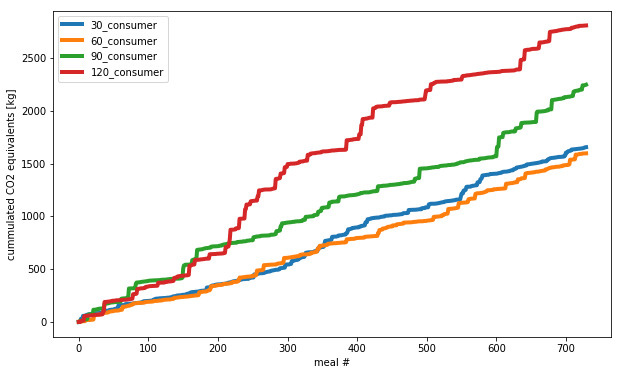

In [523]:
"""
The random walks of low and high consumers food intakes are compared!
"""
plt.figure(figsize=(10,6))
plt.plot(low_emissions.meal, low_emissions.iloc[:,0], linewidth=4)
plt.plot(low_emissions2.meal, low_emissions2.iloc[:,0], linewidth=4)
plt.plot(low_emissions3.meal, low_emissions3.iloc[:,0], linewidth=4)
plt.plot(low_emissions4.meal, low_emissions4.iloc[:,0], linewidth=4)
#plt.plot(high_emissions.meal, high_emissions.iloc[:,0], linewidth=4)
plt.title('')
plt.legend(loc='upper left')
plt.xlabel('meal #')
plt.ylabel('cummulated CO2 equivalents [kg]')
plt.show()